# AI-driven morphoclimatic regional frequency modelling of sub-daily rainfall-extremes
**Authors**: Chiara Angileri, Niccolò Marzi, Shola Oshodi

## 0. Importing libraries

In [1]:
colab = False

if colab:
    !pip install fitter
    !pip install pydot
    !pip install graphviz
    from pathlib import Path
    from google.colab import drive
    drive.mount('/content/drive')

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_probability as tfp

from scipy import stats


C:\Users\chiar\AppData\Local\Temp\ipykernel_13668\1357901882.py:11: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
from importlib import reload  
from utils import util
util = reload(util)

In [3]:
# Set random seed for reproducibility
def fix_random_seed(seed):
    np.random.seed(seed)
    tf.random.set_seed(seed)

seed=84 #24 NO, 33 NO, 42 NO, 69 SNI, 72 SNI, 1234 SI, 666 NO, 123 NO, 529 NO, 84 SI
fix_random_seed(seed)

## 1. Load and inspect the dataset

### 1.1. Load data

In [4]:
df, df_indexes_test = util.load_data(colab)
print(df.columns)

Index(['ID', 'Nome', 'HMerit_mean(m)', 'HMerit_stdev(m)', 'Slope_mean(deg)',
       'Slope_stdev(deg)', 'Aspect_mean(deg)', 'Aspect_stdev(deg)',
       'MinDistAdriaticC_(km)', 'OrogrAdri_mean (m)', 'OrogrAdri_stdev(m)',
       'OrogrAdri_max(m)', 'MinDistTirrenicC_(km)', 'OrograTirr_mean(m)',
       'OrograTirr_stdev(m)', 'OrograTirr_max(m)', 'MAP(mm)', 'MASnowP(mm)',
       'VarClimPT(mm)', 'VarClimSowP(mm)', 'X', 'Y', 'duration[h]', 'AMS',
       'mean_IdD', 'loc', 'scale', '99perc', '95perc', '80perc'],
      dtype='object')


In [5]:
df

,ID,Nome,HMerit_mean(m),HMerit_stdev(m),Slope_mean(deg),Slope_stdev(deg),Aspect_mean(deg),Aspect_stdev(deg),MinDistAdriaticC_(km),OrogrAdri_mean (m),...,X,Y,duration[h],AMS,mean_IdD,loc,scale,99perc,95perc,80perc
0,5001,'Abetone',1319.144154,85.599127,13.342638,4.979222,252.769653,96.036924,134.037400,377.648461,...,633069.81,4890553.68,1,1.221239,28.250000,0.890564,0.184415,1.738901,1.438313,1.167176
1,5001,'Abetone',1319.144154,85.599127,13.342638,4.979222,252.769653,96.036924,134.037400,377.648461,...,633069.81,4890553.68,1,0.778761,28.250000,0.890564,0.184415,1.738901,1.438313,1.167176
2,5002,'Albareto',531.112211,40.321631,7.545648,4.469855,219.061317,121.198571,203.680776,300.679959,...,555576.92,4921743.21,1,1.219018,33.469565,0.823918,0.287186,2.145015,1.676915,1.254679
3,5002,'Albareto',531.112211,40.321631,7.545648,4.469855,219.061317,121.198571,203.680776,300.679959,...,555576.92,4921743.21,1,0.979995,33.469565,0.823918,0.287186,2.145015,1.676915,1.254679
4,5002,'Albareto',531.112211,40.321631,7.545648,4.469855,219.061317,121.198571,203.680776,300.679959,...,555576.92,4921743.21,1,1.153287,33.469565,0.823918,0.287186,2.145015,1.676915,1.254679
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
274542,21338,'Vicenza_-_Sant_Agostino',33.290198,3.489680,0.844974,1.510106,172.196092,94.760327,66.170105,15.368078,...,696822.00,5044294.00,24,0.918877,82.927273,0.903636,0.193259,1.792657,1.477653,1.193513
274543,21338,'Vicenza_-_Sant_Agostino',33.290198,3.489680,0.844974,1.510106,172.196092,94.760327,66.170105,15.368078,...,696822.00,5044294.00,24,0.950230,82.927273,0.903636,0.193259,1.792657,1.477653,1.193513
274544,21338,'Vicenza_-_Sant_Agostino',33.290198,3.489680,0.844974,1.510106,172.196092,94.760327,66.170105,15.368078,...,696822.00,5044294.00,24,0.602938,82.927273,0.903636,0.193259,1.792657,1.477653,1.193513
274545,21338,'Vicenza_-_Sant_Agostino',33.290198,3.489680,0.844974,1.510106,172.196092,94.760327,66.170105,15.368078,...,696822.00,5044294.00,24,0.877878,82.927273,0.903636,0.193259,1.792657,1.477653,1.193513


### 1.2. Preprocess and split the dataset

In [6]:
# Clean the dataset from the columns that are not useful
to_remove = ['Nome', 'loc', 'scale', '99perc', '95perc', '80perc']
df = df.drop(to_remove, axis=1, inplace=False)

# Unique duration values
DURATION = df['duration[h]'].unique()
print('Durations: ', DURATION)

Durations:  [ 1  3  6 12 24]


In [7]:
#drop duplicate rows

#df = df.drop_duplicates()
#df = df.reset_index(drop=True)
#df

In [8]:
df = util.standardize(df, 'beta')

#### 1.2.1 Split the dataset into train, validation and test

In [9]:
# Take the first 100 ID and use them to create the test sets
test_ID = df_indexes_test['ID'].to_list()[:100]
test_df = df[df['ID'].isin(test_ID)]
test_df.reset_index(drop=True, inplace=True)

# Drop the test set from df and then create the train sets and validation sets
df = df.drop(df[df['ID'].isin(test_ID)].index)
df.reset_index(drop=True, inplace=True)

validation_split = 0.1
df = df.sort_values(by=['ID'])
    
train_df, val_df = train_test_split(df, test_size=validation_split, shuffle=False)
train_df.reset_index(drop=True, inplace=True)
val_df.reset_index(drop=True, inplace=True)

In [10]:
train_df.head()

,ID,AMS,mean_IdD,duration[h],HMerit_mean(m),HMerit_stdev(m),Slope_mean(deg),Slope_stdev(deg),Aspect_mean(deg),Aspect_stdev(deg),...,MinDistTirrenicC_(km),OrograTirr_mean(m),OrograTirr_stdev(m),OrograTirr_max(m),MAP(mm),MASnowP(mm),VarClimPT(mm),VarClimSowP(mm),X,Y
0,5001.0,1.221239,28.250,1.0,1.492466,0.280239,0.145097,-0.375455,2.382086,0.222372,...,-0.884287,1.114094,0.961299,0.567896,2.185839,4.641128,1.80934,4.673003,0.433955,-0.800952
1,5001.0,0.680425,199.875,24.0,1.492466,0.280239,0.145097,-0.375455,2.382086,0.222372,...,-0.884287,1.114094,0.961299,0.567896,2.185839,4.641128,1.80934,4.673003,0.433955,-0.800952
2,5001.0,0.855535,199.875,24.0,1.492466,0.280239,0.145097,-0.375455,2.382086,0.222372,...,-0.884287,1.114094,0.961299,0.567896,2.185839,4.641128,1.80934,4.673003,0.433955,-0.800952
3,5001.0,0.945591,199.875,24.0,1.492466,0.280239,0.145097,-0.375455,2.382086,0.222372,...,-0.884287,1.114094,0.961299,0.567896,2.185839,4.641128,1.80934,4.673003,0.433955,-0.800952
4,5001.0,1.518449,199.875,24.0,1.492466,0.280239,0.145097,-0.375455,2.382086,0.222372,...,-0.884287,1.114094,0.961299,0.567896,2.185839,4.641128,1.80934,4.673003,0.433955,-0.800952


#### 1.2.2 Standardize datasets

All the data is standardized using StandardScaler, while the AMS is standardized using Min-Max scaling specifying a range from 0.001 to 0.99 to respect the distribution constraints.

In [11]:
min_AMS = train_df['AMS'].min()
max_AMS = train_df['AMS'].max()

In [12]:
def scale_AMS(df, min_AMS, max_AMS, k = 1.2):
    """
        df: dataframe
        k: Multiplication factor to extend the range of AMS values. Defaults to 1.
        IdD: To specify how standardize. Defaults to False.
    """

    min_AMS = min_AMS - 1e-2 # to avoid zero values
    max_AMS = max_AMS * k

    df['AMS'] = df.apply(lambda row: (row['AMS'] - min_AMS) / (max_AMS - min_AMS), axis=1)

    return df

In [13]:
train_df_std = scale_AMS(train_df, min_AMS, max_AMS) #util.standardize(train_df, 'beta')
val_df_std = scale_AMS(val_df, min_AMS, max_AMS) #util.standardize(val_df, 'beta')
test_df_std = scale_AMS(test_df, min_AMS, max_AMS) #util.standardize(test_df, 'beta')

In [14]:
# column id must be integer
train_df_std['ID'] = train_df_std['ID'].astype(int)
val_df_std['ID'] = val_df_std['ID'].astype(int)
test_df_std['ID'] = test_df_std['ID'].astype(int)

# column duration must be integer
train_df_std['duration[h]'] = train_df_std['duration[h]'].astype(int)
val_df_std['duration[h]'] = val_df_std['duration[h]'].astype(int)
test_df_std['duration[h]'] = test_df_std['duration[h]'].astype(int)

In [15]:
train_df_std.head()

,ID,AMS,mean_IdD,duration[h],HMerit_mean(m),HMerit_stdev(m),Slope_mean(deg),Slope_stdev(deg),Aspect_mean(deg),Aspect_stdev(deg),...,MinDistTirrenicC_(km),OrograTirr_mean(m),OrograTirr_stdev(m),OrograTirr_max(m),MAP(mm),MASnowP(mm),VarClimPT(mm),VarClimSowP(mm),X,Y
0,5001,0.162028,28.250,1,1.492466,0.280239,0.145097,-0.375455,2.382086,0.222372,...,-0.884287,1.114094,0.961299,0.567896,2.185839,4.641128,1.80934,4.673003,0.433955,-0.800952
1,5001,0.090379,199.875,24,1.492466,0.280239,0.145097,-0.375455,2.382086,0.222372,...,-0.884287,1.114094,0.961299,0.567896,2.185839,4.641128,1.80934,4.673003,0.433955,-0.800952
2,5001,0.113578,199.875,24,1.492466,0.280239,0.145097,-0.375455,2.382086,0.222372,...,-0.884287,1.114094,0.961299,0.567896,2.185839,4.641128,1.80934,4.673003,0.433955,-0.800952
3,5001,0.125509,199.875,24,1.492466,0.280239,0.145097,-0.375455,2.382086,0.222372,...,-0.884287,1.114094,0.961299,0.567896,2.185839,4.641128,1.80934,4.673003,0.433955,-0.800952
4,5001,0.201403,199.875,24,1.492466,0.280239,0.145097,-0.375455,2.382086,0.222372,...,-0.884287,1.114094,0.961299,0.567896,2.185839,4.641128,1.80934,4.673003,0.433955,-0.800952


In [16]:
train_df_std.describe()

,ID,AMS,mean_IdD,duration[h],HMerit_mean(m),HMerit_stdev(m),Slope_mean(deg),Slope_stdev(deg),Aspect_mean(deg),Aspect_stdev(deg),...,MinDistTirrenicC_(km),OrograTirr_mean(m),OrograTirr_stdev(m),OrograTirr_max(m),MAP(mm),MASnowP(mm),VarClimPT(mm),VarClimSowP(mm),X,Y
count,233218.000000,233218.000000,233218.000000,233218.000000,233218.000000,233218.000000,233218.000000,233218.000000,233218.000000,233218.000000,...,233218.000000,233218.000000,233218.000000,233218.000000,233218.000000,233218.000000,233218.000000,233218.000000,233218.000000,233218.000000
mean,11047.209328,0.132716,57.052651,9.199200,0.024646,0.032570,0.042734,0.047496,0.014040,0.013421,...,-0.102764,0.028934,-0.070270,-0.067010,0.023610,0.001521,0.037728,0.004899,-0.072880,-0.075678
std,4333.130131,0.049722,31.051531,8.280664,0.984392,0.986320,0.981766,0.976423,1.004977,1.008808,...,0.986101,1.052469,1.018725,1.018695,0.996458,1.002549,0.995037,1.018041,0.989454,1.016837
min,5001.000000,0.001325,5.200000,1.000000,-1.020500,-1.181048,-1.331852,-1.503806,-4.369229,-3.522613,...,-1.470102,-1.519984,-1.779005,-1.935638,-1.583809,-0.479600,-1.528887,-0.637763,-2.037322,-1.886456
25%,8094.000000,0.099158,34.984444,3.000000,-0.708747,-0.817296,-0.887690,-0.666054,-0.578875,-0.620972,...,-0.984027,-0.582172,-0.864855,-0.799420,-0.757122,-0.452740,-0.764904,-0.515773,-0.969827,-0.868411
50%,12005.000000,0.123613,49.674286,6.000000,-0.264208,-0.091967,0.073687,0.116867,0.016296,0.066203,...,-0.148547,-0.118672,-0.208966,-0.251402,-0.210103,-0.420647,-0.187105,-0.435802,0.079379,-0.371707
75%,16065.000000,0.155470,70.343750,12.000000,0.480086,0.640557,0.730073,0.713190,0.644833,0.693127,...,0.563731,0.423661,0.582830,0.456927,0.596341,-0.225321,0.667556,-0.095920,0.699596,0.724815
max,20034.000000,0.833372,318.742857,24.000000,5.244876,3.734721,2.928541,3.520526,3.648847,2.935948,...,2.408305,5.536860,3.648605,3.272980,4.323812,7.312002,3.537003,6.218626,2.054450,2.471653


### 1.3 Add the guesses to datasets

Addition of estimated values of alpha e beta to be used as ground truth.

In [17]:
def add_alpha_beta(df):
 
    # create two empy columns for alpha and beta
    df['alpha'] = np.nan
    df['beta'] = np.nan
 
    for id in df['ID'].unique():
       
        for duration in DURATION:
            condition = (df['ID'] == id) & (df['duration[h]'] == duration)
            ams = df[condition]['AMS']
           
            
            if len(ams) < 29:
                a, b = np.nan, np.nan
            else:
                a, b, _, _ = stats.beta.fit(ams, floc=0, fscale=1)
                
                        
            df.loc[condition, 'alpha'] = a
            df.loc[condition, 'beta'] = b
 
    # if there are nan values
    #if df.isnull().values.any():
        #raise Exception('There are nan values in the dataframe')
    df.dropna(inplace=True)
 
    return df

In [18]:
#train_df_std = add_alpha_beta(train_df_std)
#val_df_std = add_alpha_beta(val_df_std)
test_df_std = add_alpha_beta(test_df_std)

In [19]:
test_df_std

,ID,AMS,mean_IdD,duration[h],HMerit_mean(m),HMerit_stdev(m),Slope_mean(deg),Slope_stdev(deg),Aspect_mean(deg),Aspect_stdev(deg),...,OrograTirr_stdev(m),OrograTirr_max(m),MAP(mm),MASnowP(mm),VarClimPT(mm),VarClimSowP(mm),X,Y,alpha,beta
0,5005,0.212248,24.120313,1,-0.953135,-1.161219,-1.317728,-1.484804,-1.151235,0.700014,...,0.706214,0.217943,-1.015168,-0.419278,-1.105430,-0.417212,0.749152,-0.274367,6.145536,40.062161
1,5005,0.283651,24.120313,1,-0.953135,-1.161219,-1.317728,-1.484804,-1.151235,0.700014,...,0.706214,0.217943,-1.015168,-0.419278,-1.105430,-0.417212,0.749152,-0.274367,6.145536,40.062161
2,5005,0.108988,24.120313,1,-0.953135,-1.161219,-1.317728,-1.484804,-1.151235,0.700014,...,0.706214,0.217943,-1.015168,-0.419278,-1.105430,-0.417212,0.749152,-0.274367,6.145536,40.062161
3,5005,0.147436,24.120313,1,-0.953135,-1.161219,-1.317728,-1.484804,-1.151235,0.700014,...,0.706214,0.217943,-1.015168,-0.419278,-1.105430,-0.417212,0.749152,-0.274367,6.145536,40.062161
4,5005,0.112832,24.120313,1,-0.953135,-1.161219,-1.317728,-1.484804,-1.151235,0.700014,...,0.706214,0.217943,-1.015168,-0.419278,-1.105430,-0.417212,0.749152,-0.274367,6.145536,40.062161
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15396,17020,0.148556,94.501724,24,1.103794,0.688075,0.341981,0.263542,1.461785,-2.354561,...,0.814081,0.447436,0.251079,1.238917,0.127232,1.457976,0.706573,1.355187,5.697800,37.172138
15397,17020,0.277812,94.501724,24,1.103794,0.688075,0.341981,0.263542,1.461785,-2.354561,...,0.814081,0.447436,0.251079,1.238917,0.127232,1.457976,0.706573,1.355187,5.697800,37.172138
15398,17020,0.082106,94.501724,24,1.103794,0.688075,0.341981,0.263542,1.461785,-2.354561,...,0.814081,0.447436,0.251079,1.238917,0.127232,1.457976,0.706573,1.355187,5.697800,37.172138
15399,17020,0.122481,94.501724,24,1.103794,0.688075,0.341981,0.263542,1.461785,-2.354561,...,0.814081,0.447436,0.251079,1.238917,0.127232,1.457976,0.706573,1.355187,5.697800,37.172138


In [20]:
test_df_std.describe()

,ID,AMS,mean_IdD,duration[h],HMerit_mean(m),HMerit_stdev(m),Slope_mean(deg),Slope_stdev(deg),Aspect_mean(deg),Aspect_stdev(deg),...,OrograTirr_stdev(m),OrograTirr_max(m),MAP(mm),MASnowP(mm),VarClimPT(mm),VarClimSowP(mm),X,Y,alpha,beta
count,11285.000000,11285.000000,11285.000000,11285.000000,11285.000000,11285.000000,11285.000000,11285.000000,11285.000000,11285.000000,...,11285.000000,11285.000000,11285.000000,11285.000000,11285.000000,11285.000000,11285.000000,11285.000000,11285.000000,11285.000000
mean,9388.486309,0.132717,53.389238,9.193265,-0.135534,-0.098801,-0.058558,-0.025404,-0.013351,0.018984,...,-0.146973,-0.169916,-0.164429,-0.156914,-0.181487,-0.123991,0.094301,-0.276386,7.726607,50.404912
std,4006.986916,0.050603,25.339568,8.276588,0.841154,0.770955,0.862143,0.850117,1.085688,1.011784,...,0.767358,0.757411,0.701201,0.774698,0.703181,0.732626,0.954386,0.814122,3.048873,19.957420
min,5005.000000,0.010138,14.084211,1.000000,-1.009689,-1.175269,-1.323226,-1.491195,-2.291033,-2.354561,...,-1.687739,-1.819163,-1.203529,-0.479438,-1.284296,-0.634905,-1.830377,-1.411290,2.875782,18.597790
25%,5271.000000,0.098394,35.077632,3.000000,-0.690319,-0.621644,-0.704401,-0.544517,-0.756544,-0.878397,...,-0.775337,-0.778631,-0.764794,-0.444082,-0.755014,-0.499707,-0.569689,-0.832396,5.697800,37.172138
50%,8264.000000,0.122983,46.877778,6.000000,-0.378238,-0.199514,-0.223666,0.085177,-0.052995,0.225537,...,-0.144599,-0.027796,-0.257841,-0.418055,-0.303357,-0.417212,0.115927,-0.476440,7.160783,46.662714
75%,12126.000000,0.154909,66.046429,12.000000,0.194700,0.381565,0.583281,0.488076,0.523139,0.751791,...,0.601957,0.381356,0.251079,-0.269434,0.354140,-0.099526,0.722895,0.101654,9.177585,59.917772
max,17020.000000,0.493150,159.706452,24.000000,3.872997,1.950422,1.728633,1.872668,2.534594,1.634612,...,1.032581,1.888002,1.436162,5.033453,1.659962,3.462024,1.879586,1.764573,23.401321,152.888309


In [21]:
#util.geographic_plot(train_df_std, 'alpha', 'beta')

In [22]:
#histogram of AMS when alpha > 90 and beta > 500

'''
condition = (train_df_std['alpha'] > 90) & (train_df_std['beta'] > 500)
ams = train_df_std[condition]['AMS']
print(len(ams))
print(ams.values)
a, b, _, _ = stats.beta.fit(ams, floc=0, fscale=1)
print(a, b)
m, d = stats.norm.fit(ams)
print(m, d)

x = np.linspace(0, 1, 100)
dist_norm = stats.norm.pdf(x, m, d)
dist_beta = stats.beta.pdf(x, a, b)

plt.plot(x, dist_norm, 'r-', lw=1, alpha=0.6, label='norm pdf')
plt.plot(x, dist_beta, 'b-', lw=1, alpha=0.6, label='beta pdf')
plt.legend()
plt.show()
'''

"\ncondition = (train_df_std['alpha'] > 90) & (train_df_std['beta'] > 500)\nams = train_df_std[condition]['AMS']\nprint(len(ams))\nprint(ams.values)\na, b, _, _ = stats.beta.fit(ams, floc=0, fscale=1)\nprint(a, b)\nm, d = stats.norm.fit(ams)\nprint(m, d)\n\nx = np.linspace(0, 1, 100)\ndist_norm = stats.norm.pdf(x, m, d)\ndist_beta = stats.beta.pdf(x, a, b)\n\nplt.plot(x, dist_norm, 'r-', lw=1, alpha=0.6, label='norm pdf')\nplt.plot(x, dist_beta, 'b-', lw=1, alpha=0.6, label='beta pdf')\nplt.legend()\nplt.show()\n"

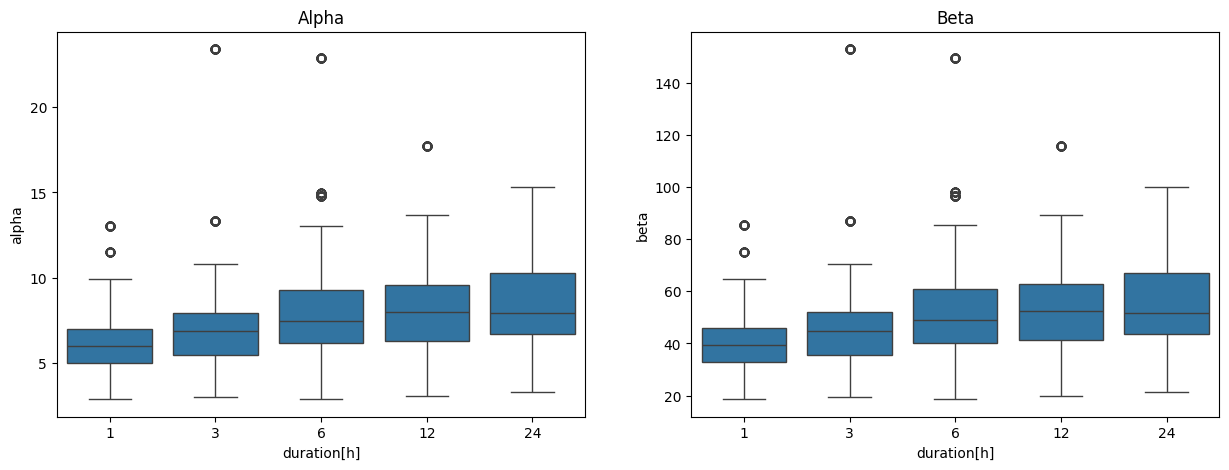

In [23]:
#boxplot of alpha and beta
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

sns.boxplot(x='duration[h]', y='alpha', data=test_df_std, ax=ax[0])
ax[0].set_title('Alpha')

sns.boxplot(x='duration[h]', y='beta', data=test_df_std, ax=ax[1])
ax[1].set_title('Beta')

plt.show()

In [24]:
#take the ID with the highest alpha and beta for each duration
'''
def get_highest_alpha_beta(df, duration):
    highest_alpha = df[df['duration[h]']==duration]['alpha'].max()
    highest_beta = df[df['duration[h]']==duration]['beta'].max()
    return highest_alpha, highest_beta

for duration in DURATION:
    highest_alpha, highest_beta = get_highest_alpha_beta(train_df_std, duration)
    highest_alpha_ID = train_df_std.loc[train_df_std['alpha'] == highest_alpha, 'ID'].values[0] # [0] because the array contains the same value repeated
    highest_beta_ID = train_df_std.loc[train_df_std['beta'] == highest_beta, 'ID'].values[0]
    
    print('Duration: ', duration)
    print('Highest alpha: ', highest_alpha)
    print('Highest alpha ID: ', highest_alpha_ID)
    print('Highest beta: ', highest_beta)
    print('Highest beta ID: ', highest_beta_ID)
    ams = train_df_std[(train_df_std['ID']==highest_beta_ID)&(train_df_std['duration[h]']==duration)]['AMS']
    print('\t AMS:', ams.values)
    print('\n')
    
'''

"\ndef get_highest_alpha_beta(df, duration):\n    highest_alpha = df[df['duration[h]']==duration]['alpha'].max()\n    highest_beta = df[df['duration[h]']==duration]['beta'].max()\n    return highest_alpha, highest_beta\n\nfor duration in DURATION:\n    highest_alpha, highest_beta = get_highest_alpha_beta(train_df_std, duration)\n    highest_alpha_ID = train_df_std.loc[train_df_std['alpha'] == highest_alpha, 'ID'].values[0] # [0] because the array contains the same value repeated\n    highest_beta_ID = train_df_std.loc[train_df_std['beta'] == highest_beta, 'ID'].values[0]\n    \n    print('Duration: ', duration)\n    print('Highest alpha: ', highest_alpha)\n    print('Highest alpha ID: ', highest_alpha_ID)\n    print('Highest beta: ', highest_beta)\n    print('Highest beta ID: ', highest_beta_ID)\n    ams = train_df_std[(train_df_std['ID']==highest_beta_ID)&(train_df_std['duration[h]']==duration)]['AMS']\n    print('\t AMS:', ams.values)\n    print('\n')\n    \n"

In [25]:
AMS_count = test_df_std.groupby(['ID','duration[h]'])['AMS'].count()
AMS_count = pd.DataFrame(AMS_count)
AMS_count.columns = ['count']
AMS_count['alpha'] = test_df_std.groupby(['ID','duration[h]'])['alpha'].mean() #prendo la media tanto lo stesso valore è ripetuto
AMS_count['beta'] = test_df_std.groupby(['ID','duration[h]'])['beta'].mean()

AMS_count.head(15)

count      alpha       beta
ID   duration[h]                             
5005 1               64   6.145536  40.062161
     3               64   6.466980  42.186205
     6               64   6.738325  43.946197
     12              64   7.092887  46.264897
     24              64   7.923504  51.697552
5015 1               76   9.763162  63.785579
     3               76  13.345923  87.165035
     6               77  13.060766  85.274155
     12              78  12.735943  83.167007
     24              77  10.891209  71.105370
5143 1               69   7.009686  45.749088
     3               70   7.947968  51.909050
     6               70   9.029417  59.024064
     12              70   6.095201  39.780175
     24              70   8.588206  56.098673

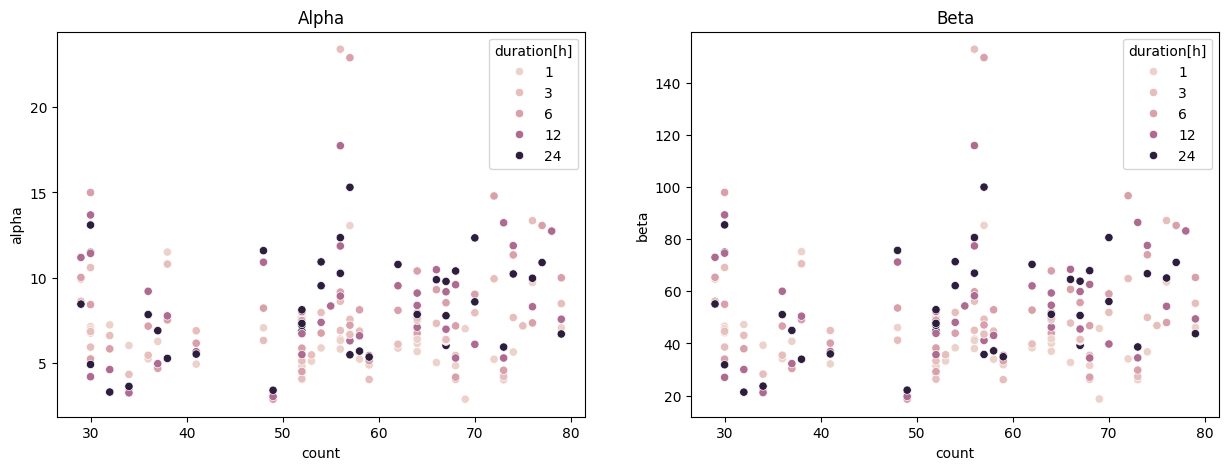

In [26]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

sns.scatterplot(x='count', y='alpha', data=AMS_count, ax=ax[0], hue='duration[h]')
ax[0].set_title('Alpha')

sns.scatterplot(x='count', y='beta', data=AMS_count, ax=ax[1], hue='duration[h]')
ax[1].set_title('Beta')

plt.show()

### 1.4. Prepare data for training

In [27]:
# sort the dataframes by ID and then by duration
train_df_std = train_df_std.sort_values(by=['ID', 'duration[h]'])
val_df_std = val_df_std.sort_values(by=['ID', 'duration[h]'])
test_df_std = test_df_std.sort_values(by=['ID', 'duration[h]'])

# create a dict to store the indexes of same durations
durations_indexes_train = {}
for duration in DURATION:
    durations_indexes_train[duration] = train_df_std[train_df_std['duration[h]'] == duration].index

durations_indexes_val = {}
for duration in DURATION:
    durations_indexes_val[duration] = val_df_std[val_df_std['duration[h]'] == duration].index

durations_indexes_test = {}
for duration in DURATION:
    durations_indexes_test[duration] = test_df_std[test_df_std['duration[h]'] == duration].index

In [28]:
train_df_std.columns

Index(['ID', 'AMS', 'mean_IdD', 'duration[h]', 'HMerit_mean(m)',
       'HMerit_stdev(m)', 'Slope_mean(deg)', 'Slope_stdev(deg)',
       'Aspect_mean(deg)', 'Aspect_stdev(deg)', 'MinDistAdriaticC_(km)',
       'OrogrAdri_mean (m)', 'OrogrAdri_stdev(m)', 'OrogrAdri_max(m)',
       'MinDistTirrenicC_(km)', 'OrograTirr_mean(m)', 'OrograTirr_stdev(m)',
       'OrograTirr_max(m)', 'MAP(mm)', 'MASnowP(mm)', 'VarClimPT(mm)',
       'VarClimSowP(mm)', 'X', 'Y'],
      dtype='object')

In [29]:
test_df_std.columns

Index(['ID', 'AMS', 'mean_IdD', 'duration[h]', 'HMerit_mean(m)',
       'HMerit_stdev(m)', 'Slope_mean(deg)', 'Slope_stdev(deg)',
       'Aspect_mean(deg)', 'Aspect_stdev(deg)', 'MinDistAdriaticC_(km)',
       'OrogrAdri_mean (m)', 'OrogrAdri_stdev(m)', 'OrogrAdri_max(m)',
       'MinDistTirrenicC_(km)', 'OrograTirr_mean(m)', 'OrograTirr_stdev(m)',
       'OrograTirr_max(m)', 'MAP(mm)', 'MASnowP(mm)', 'VarClimPT(mm)',
       'VarClimSowP(mm)', 'X', 'Y', 'alpha', 'beta'],
      dtype='object')

In [30]:
# take all the columns except 'ID', 'AMS', 'mean_IdD' as input, and 'AMS' as output
columns = train_df_std.columns
input_columns_train = train_df_std.columns[3:] 
input_columns_test = test_df_std.columns[3:-2]
output_column = 'AMS'
parameters_columns = ['ID','duration[h]','alpha', 'beta']
print('Input columns: ', input_columns_train)

Input columns:  Index(['duration[h]', 'HMerit_mean(m)', 'HMerit_stdev(m)', 'Slope_mean(deg)',
       'Slope_stdev(deg)', 'Aspect_mean(deg)', 'Aspect_stdev(deg)',
       'MinDistAdriaticC_(km)', 'OrogrAdri_mean (m)', 'OrogrAdri_stdev(m)',
       'OrogrAdri_max(m)', 'MinDistTirrenicC_(km)', 'OrograTirr_mean(m)',
       'OrograTirr_stdev(m)', 'OrograTirr_max(m)', 'MAP(mm)', 'MASnowP(mm)',
       'VarClimPT(mm)', 'VarClimSowP(mm)', 'X', 'Y'],
      dtype='object')


In [31]:
inputs_train = train_df_std[input_columns_train]
outputs_train = train_df_std[output_column]
#parameters_train = train_df_std[parameters_columns]

inputs_val = val_df_std[input_columns_train]
outputs_val = val_df_std[output_column]
#parameters_val = val_df_std[parameters_columns]

inputs_test = test_df_std[input_columns_test]
outputs_test = test_df_std[output_column]
parameters_test = test_df_std[parameters_columns]

In [32]:
#make ohe for duration

inputs_train = pd.get_dummies(inputs_train, columns=['duration[h]'])
inputs_val = pd.get_dummies(inputs_val, columns=['duration[h]'])
inputs_test = pd.get_dummies(inputs_test, columns=['duration[h]'])

for duration in DURATION:
    inputs_train['duration[h]_'+str(duration)] = inputs_train['duration[h]_'+str(duration)].astype(int)
    inputs_val['duration[h]_'+str(duration)] = inputs_val['duration[h]_'+str(duration)].astype(int)
    inputs_test['duration[h]_'+str(duration)] = inputs_test['duration[h]_'+str(duration)].astype(int)

inputs_train

,HMerit_mean(m),HMerit_stdev(m),Slope_mean(deg),Slope_stdev(deg),Aspect_mean(deg),Aspect_stdev(deg),MinDistAdriaticC_(km),OrogrAdri_mean (m),OrogrAdri_stdev(m),OrogrAdri_max(m),...,MASnowP(mm),VarClimPT(mm),VarClimSowP(mm),X,Y,duration[h]_1,duration[h]_3,duration[h]_6,duration[h]_12,duration[h]_24
0,1.492466,0.280239,0.145097,-0.375455,2.382086,0.222372,-0.501572,0.431856,0.617256,0.685301,...,4.641128,1.809340,4.673003,0.433955,-0.800952,1,0,0,0,0
15,1.492466,0.280239,0.145097,-0.375455,2.382086,0.222372,-0.501572,0.431856,0.617256,0.685301,...,4.641128,1.809340,4.673003,0.433955,-0.800952,1,0,0,0,0
5,1.492466,0.280239,0.145097,-0.375455,2.382086,0.222372,-0.501572,0.431856,0.617256,0.685301,...,4.641128,1.809340,4.673003,0.433955,-0.800952,0,1,0,0,0
6,1.492466,0.280239,0.145097,-0.375455,2.382086,0.222372,-0.501572,0.431856,0.617256,0.685301,...,4.641128,1.809340,4.673003,0.433955,-0.800952,0,1,0,0,0
7,1.492466,0.280239,0.145097,-0.375455,2.382086,0.222372,-0.501572,0.431856,0.617256,0.685301,...,4.641128,1.809340,4.673003,0.433955,-0.800952,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
233201,1.388059,0.794012,0.723450,1.168126,-0.481020,0.092271,1.917143,0.718205,1.647284,1.950180,...,1.506071,0.839122,1.687942,-1.847247,1.192131,0,0,0,0,1
233202,1.388059,0.794012,0.723450,1.168126,-0.481020,0.092271,1.917143,0.718205,1.647284,1.950180,...,1.506071,0.839122,1.687942,-1.847247,1.192131,0,0,0,0,1
233203,1.388059,0.794012,0.723450,1.168126,-0.481020,0.092271,1.917143,0.718205,1.647284,1.950180,...,1.506071,0.839122,1.687942,-1.847247,1.192131,0,0,0,0,1
233204,1.388059,0.794012,0.723450,1.168126,-0.481020,0.092271,1.917143,0.718205,1.647284,1.950180,...,1.506071,0.839122,1.687942,-1.847247,1.192131,0,0,0,0,1


In [33]:
#MAP
inputs_train_map = inputs_train[['MAP(mm)','duration[h]_1','duration[h]_3','duration[h]_6','duration[h]_12','duration[h]_24']]
inputs_val_map = inputs_val[['MAP(mm)','duration[h]_1','duration[h]_3','duration[h]_6','duration[h]_12','duration[h]_24']]
inputs_test_map = inputs_test[['MAP(mm)','duration[h]_1','duration[h]_3','duration[h]_6','duration[h]_12','duration[h]_24']]

inputs_train_map

,MAP(mm),duration[h]_1,duration[h]_3,duration[h]_6,duration[h]_12,duration[h]_24
0,2.185839,1,0,0,0,0
15,2.185839,1,0,0,0,0
5,2.185839,0,1,0,0,0
6,2.185839,0,1,0,0,0
7,2.185839,0,1,0,0,0
...,...,...,...,...,...,...
233201,-0.125310,0,0,0,0,1
233202,-0.125310,0,0,0,0,1
233203,-0.125310,0,0,0,0,1
233204,-0.125310,0,0,0,0,1


In [34]:
#PCA
inputs_train_pca = util.make_pca(inputs_train, 5)
inputs_val_pca = util.make_pca(inputs_val, 5)
inputs_test_pca = util.make_pca(inputs_test, 5)

inputs_train_pca

,0,1,2,3,4
0,4.122771,-0.393521,-0.708337,5.286269,0.040013
1,4.122771,-0.393521,-0.708337,5.286269,0.040013
2,4.122777,-0.393565,-0.708371,5.286445,0.040039
3,4.122777,-0.393565,-0.708371,5.286445,0.040039
4,4.122777,-0.393565,-0.708371,5.286445,0.040039
...,...,...,...,...,...
233213,5.980451,1.973480,2.164376,-0.433023,0.024087
233214,5.980451,1.973480,2.164376,-0.433023,0.024087
233215,5.980451,1.973480,2.164376,-0.433023,0.024087
233216,5.980451,1.973480,2.164376,-0.433023,0.024087


## 2. Model definition

#### Base model

In [35]:
def build_nn_beta_model(input_shape, hidden,seed):
    model_in = keras.Input(shape=input_shape, dtype='float64')
    x = model_in
    for h in hidden:
        x = layers.Dense(h, activation='relu',kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed))(x)

    alpha_beta = layers.Dense(2, activation='exponential',kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed))(x)

    lf = lambda t: tfp.distributions.Beta(concentration0=t[:,0:1], concentration1=t[:,1:2], validate_args=True, allow_nan_stats=False)
    model_out = tfp.layers.DistributionLambda(lf)(alpha_beta)
    model = keras.Model(model_in, model_out)
    return model

## 3. Training

### 3.1 Map-Model

In [36]:
y_train  = outputs_train.values
y_val = outputs_val.values
y_test = outputs_test.values

In [37]:
# Parameters for the training
batch_size = 128
epochs = 90 
lr = 1e-3
patience = 30
loss_prof = lambda y_true, dist: -dist.log_prob(y_true)

Training the model with only MAP descriptor...

Epoch 1/90

1823/1823 [==============================] - 6s 2ms/step - loss: -1.6471 - val_loss: -1.6792
Epoch 2/90
1823/1823 [==============================] - 4s 2ms/step - loss: -1.6701 - val_loss: -1.7223
Epoch 3/90
1823/1823 [==============================] - 4s 2ms/step - loss: -1.6720 - val_loss: -1.7085
Epoch 4/90
1823/1823 [==============================] - 4s 2ms/step - loss: -1.6732 - val_loss: -1.7206
Epoch 5/90
1823/1823 [==============================] - 4s 2ms/step - loss: -1.6739 - val_loss: -1.7184
Epoch 6/90
1823/1823 [==============================] - 4s 2ms/step - loss: -1.6741 - val_loss: -1.7167
Epoch 7/90
1823/1823 [==============================] - 4s 2ms/step - loss: -1.6748 - val_loss: -1.7241
Epoch 8/90
1823/1823 [==============================] - 4s 2ms/step - loss: -1.6740 - val_loss: -1.6997
Epoch 9/90
1823/1823 [==============================] - 4s 2ms/step - loss: -1.6750 - val_loss: -1.7087
Epoch 10/90
182

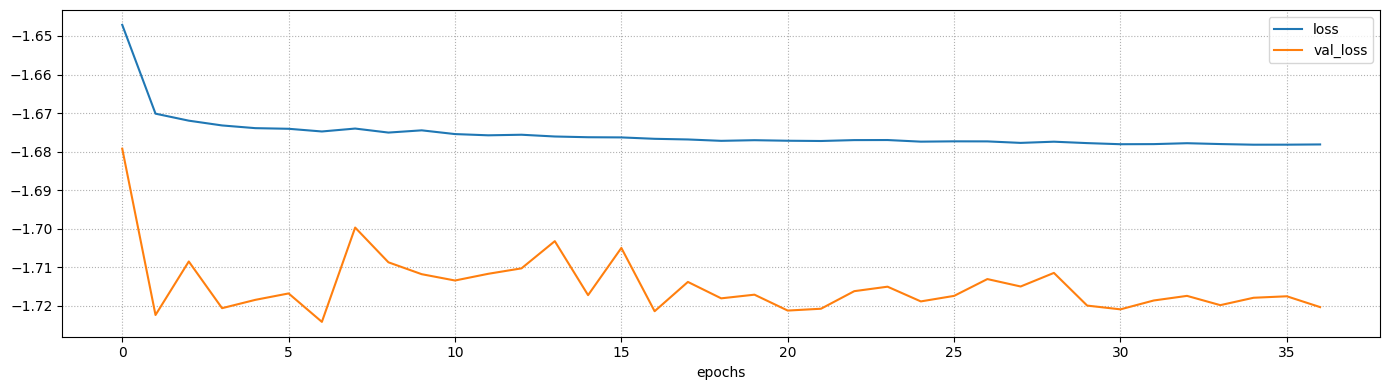

Final loss: -1.6781 (training), -1.7203 (validation)


In [38]:
X_train_map = inputs_train_map.values
X_val_map = inputs_val_map.values
X_test_map = inputs_test_map.values

print('Training the model with only MAP descriptor...')
map_model = build_nn_beta_model(input_shape=(X_train_map.shape[1],), hidden=[256,128],seed=seed) #[256,128]
history = util.train_nn_model(map_model, X_train_map, y_train, batch_size, loss_prof, lr, epochs, verbose=1, patience=patience, validation_data=(X_val_map, y_val))
util.plot_training_history(history, figsize=(14, 4))


### 3.2 Full-model

Training the model with all morphoclimatic descriptors...
Epoch 1/90
1823/1823 [==============================] - 7s 3ms/step - loss: -1.6386 - val_loss: -1.6332
Epoch 2/90
1823/1823 [==============================] - 4s 2ms/step - loss: -1.6730 - val_loss: -1.6894
Epoch 3/90
1823/1823 [==============================] - 4s 2ms/step - loss: -1.6789 - val_loss: -1.7062
Epoch 4/90
1823/1823 [==============================] - 4s 2ms/step - loss: -1.6817 - val_loss: -1.6974
Epoch 5/90
1823/1823 [==============================] - 4s 2ms/step - loss: -1.6847 - val_loss: -1.7182
Epoch 6/90
1823/1823 [==============================] - 4s 2ms/step - loss: -1.6863 - val_loss: -1.6658
Epoch 7/90
1823/1823 [==============================] - 4s 2ms/step - loss: -1.6879 - val_loss: -1.7053
Epoch 8/90
1823/1823 [==============================] - 4s 2ms/step - loss: -1.6878 - val_loss: -1.7231
Epoch 9/90
1823/1823 [==============================] - 4s 2ms/step - loss: -1.6902 - val_loss: -1.7244
Epoch 

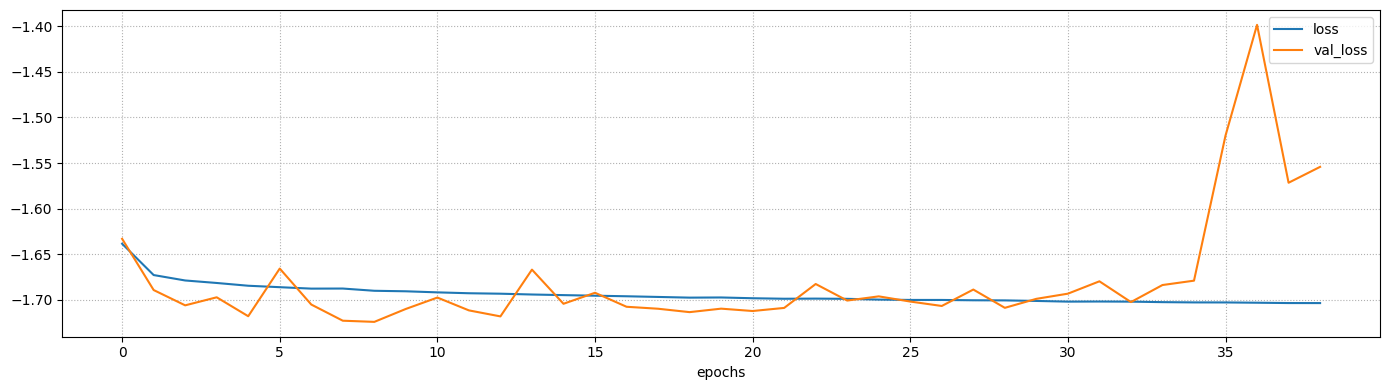

Final loss: -1.7037 (training), -1.5542 (validation)


In [39]:
X_train = inputs_train.values
X_val = inputs_val.values
X_test = inputs_test.values

print('Training the model with all morphoclimatic descriptors...')
full_model = build_nn_beta_model(input_shape=(X_train.shape[1],), hidden=[256,128],seed=seed) #[256,128]
history = util.train_nn_model(full_model, X_train, y_train, batch_size, loss_prof, lr, epochs, verbose=1, patience=patience, validation_data=(X_val, y_val))
util.plot_training_history(history, figsize=(14, 4))

### 3.3  PCA-model

Training the model with the PCA of the morphoclimatic descriptors...
Epoch 1/90
1823/1823 [==============================] - 6s 2ms/step - loss: -1.6271 - val_loss: -1.6791
Epoch 2/90
1823/1823 [==============================] - 4s 2ms/step - loss: -1.6723 - val_loss: -1.7093
Epoch 3/90
1823/1823 [==============================] - 6s 3ms/step - loss: -1.6770 - val_loss: -1.7079
Epoch 4/90
1823/1823 [==============================] - 7s 4ms/step - loss: -1.6790 - val_loss: -1.7122
Epoch 5/90
1823/1823 [==============================] - 7s 4ms/step - loss: -1.6808 - val_loss: -1.7135
Epoch 6/90
1823/1823 [==============================] - 5s 3ms/step - loss: -1.6812 - val_loss: -1.7118
Epoch 7/90
1823/1823 [==============================] - 5s 3ms/step - loss: -1.6822 - val_loss: -1.7183
Epoch 8/90
1823/1823 [==============================] - 4s 2ms/step - loss: -1.6813 - val_loss: -1.7069
Epoch 9/90
1823/1823 [==============================] - 4s 2ms/step - loss: -1.6831 - val_loss: -1.

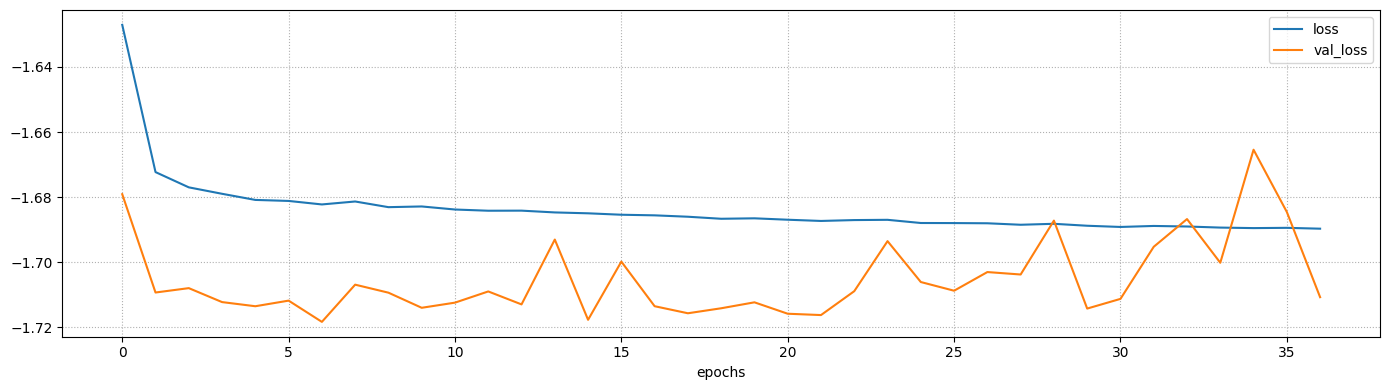

Final loss: -1.6897 (training), -1.7107 (validation)


In [40]:
X_train_pca = inputs_train_pca.values
X_val_pca = inputs_val_pca.values
X_test_pca = inputs_test_pca.values

print('Training the model with the PCA of the morphoclimatic descriptors...')
pca_model = build_nn_beta_model(input_shape=(X_train_pca.shape[1],), hidden=[256,128],seed=seed) #[256,128]
history = util.train_nn_model(pca_model, X_train_pca, y_train, batch_size, loss_prof, lr, epochs, verbose=1, patience=patience, validation_data=(X_val_pca, y_val))
util.plot_training_history(history, figsize=(14, 4))

## 4. Evaluation

In [116]:
'''model_names = [ 'MAP', 'Full', 'PCA']
splits = ['Train', 'Validation', 'Test']
models = [map_model, full_model, pca_model]
X_values = {'MAP':[X_train_map, X_val_map, X_test_map], 'Full':[X_train, X_val, X_test], 'PCA':[X_train_pca, X_val_pca, X_test_pca]}
y_values = [y_train, y_val, y_test]'''

dist_train_map = map_model(X_train_map)
dist_val_map = map_model(X_val_map)
dist_test_map = map_model(X_test_map)

dist_train_full = full_model(X_train)
dist_val_full = full_model(X_val)
dist_test_full = full_model(X_test)

dist_train_pca = pca_model(X_train_pca)
dist_val_pca = pca_model(X_val_pca)
dist_test_pca = pca_model(X_test_pca)


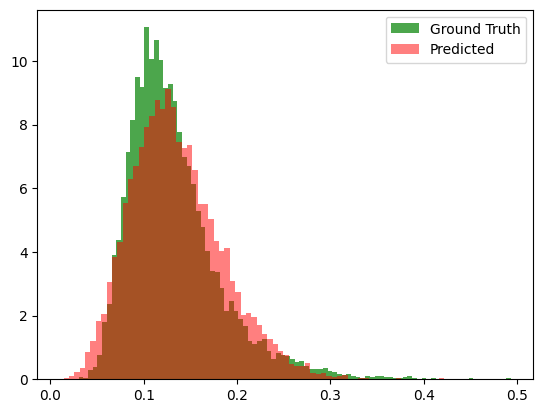

In [115]:
y_pred = dist_test_full.sample(1).numpy().ravel()
#y_pred = dist_train_map.sample(1).numpy().ravel()
#y_pred = dist_test_pca.sample(1).numpy().ravel()

util.plot_hist_samples(y_test, y_pred, 'red')

### 5.1.1 Distribution mean - confidence interval 

In [45]:
confidence = 0.99

Evaluation of MAP-model based on confidence intervals..


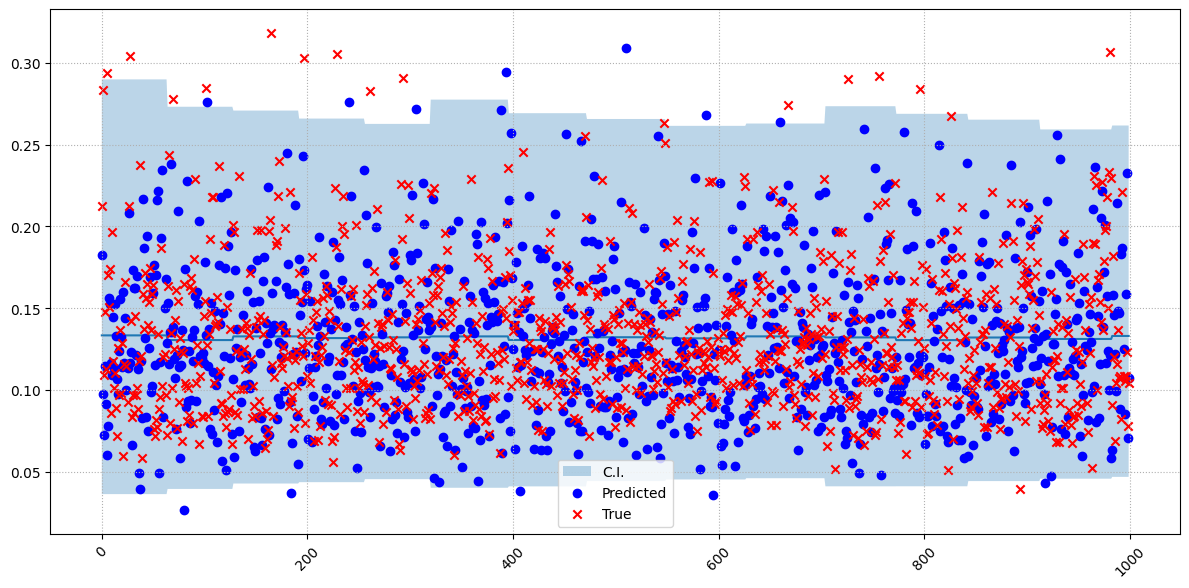

Percentage of values inside the 99% confidence interval: 97.62%


In [46]:
print('Evaluation of MAP-model based on confidence intervals..')
inside = util.percentage_in_ci(inputs_test_map, y_test, dist_test_map, confidence, distribution = 'beta', end = 1000)
print(f'Percentage of values inside the {confidence*100:.0f}% confidence interval: {inside:.2f}%')

Evaluation of Full-model based on confidence intervals..


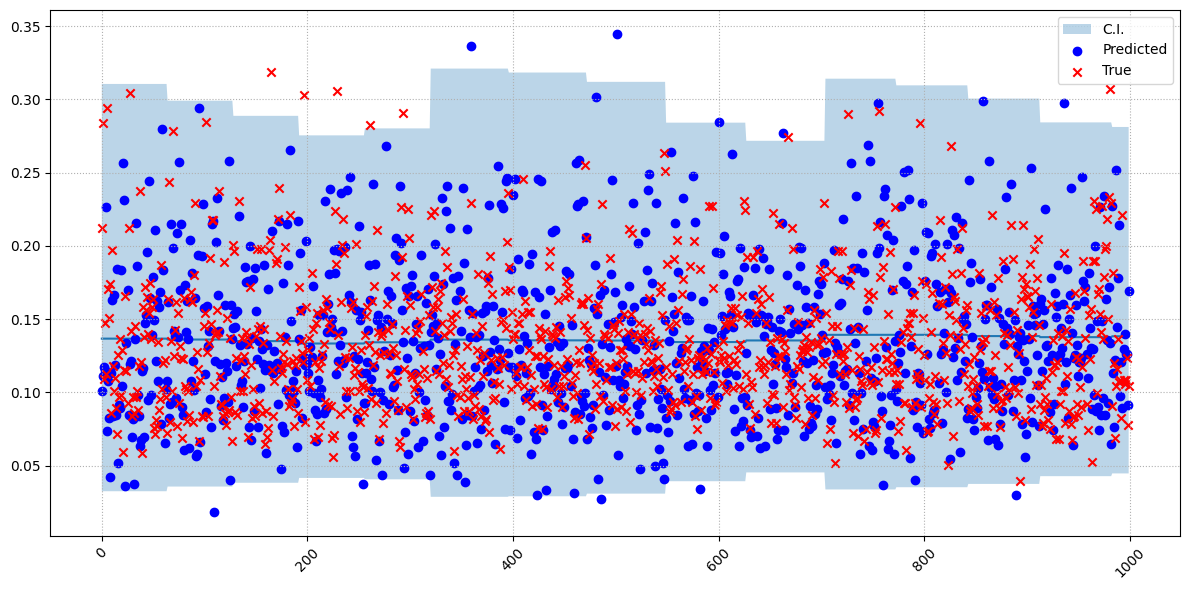

Percentage of values inside the 99% confidence interval: 98.43%


In [47]:
print('Evaluation of Full-model based on confidence intervals..')
inside = util.percentage_in_ci(inputs_test, y_test, dist_test_full, confidence, distribution = 'beta', end = 1000)
print(f'Percentage of values inside the {confidence*100:.0f}% confidence interval: {inside:.2f}%')

Evaluation of PCA-model based on confidence intervals..


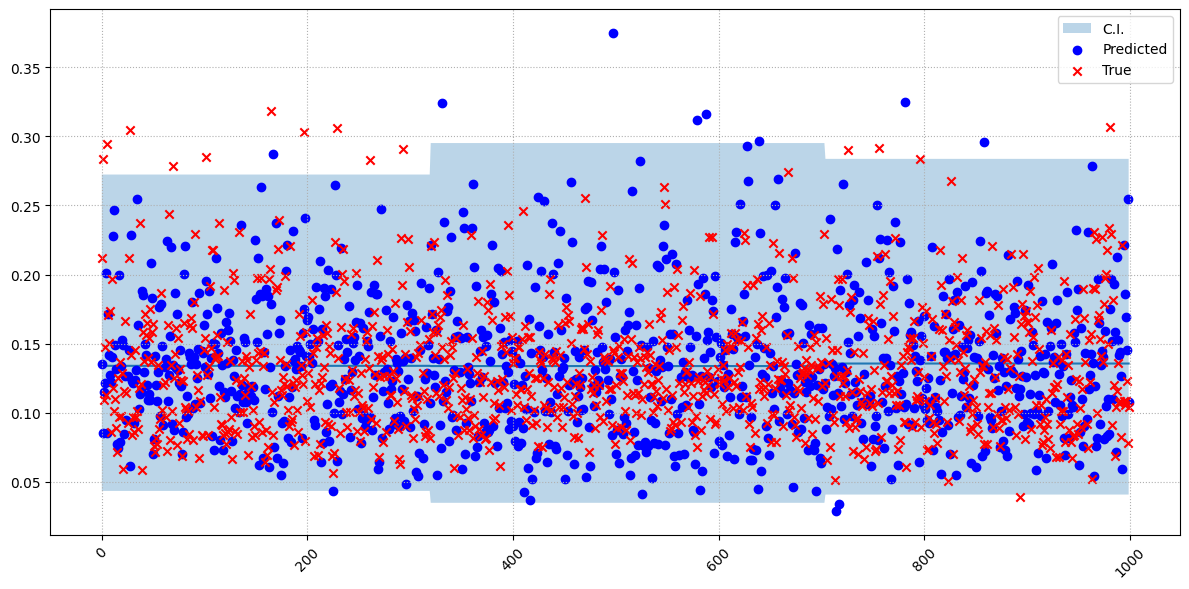

Percentage of values inside the 99% confidence interval: 97.50%


In [48]:
print('Evaluation of PCA-model based on confidence intervals..')
inside = util.percentage_in_ci(inputs_test_pca, y_test, dist_test_pca, confidence, distribution = 'beta', end = 1000)
print(f'Percentage of values inside the {confidence*100:.0f}% confidence interval: {inside:.2f}%')

## 5. Parameters

* Metrics on parameters from MAP-model

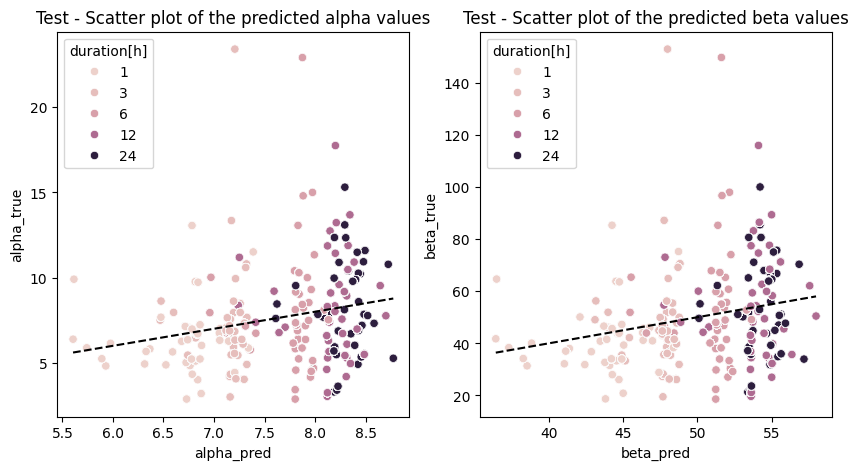

In [49]:
#Train
#_ = util.parameters_metrics(dist_train_map, parameters_train, distribution_name = 'beta', calculate_metrics = False, title='Train') 
#Test
metrics_alpha_map, metrics_beta_map = util.parameters_metrics(dist_test_map, parameters_test, distribution_name='beta', indexes=durations_indexes_test, remove_outliers = False)

In [50]:
print('===============ALPHA PARAMETER===============')
display(metrics_alpha_map)
print('===============BETA PARAMETER===============')
metrics_beta_map

===============ALPHA PARAMETER===============


,global,1,3,6,12,24
biasr,-0.117680,-0.160442,-0.115088,-0.105595,-0.109987,-0.097220
mape,0.295592,0.271872,0.277661,0.316469,0.314314,0.297653
pcc,0.260718,0.092340,0.021777,0.088410,0.026096,0.053886


===============BETA PARAMETER===============


,global,1,3,6,12,24
biasr,-0.128304,-0.162682,-0.140326,-0.112675,-0.125015,-0.100752
mape,0.301395,0.275026,0.289974,0.321053,0.320693,0.300234
pcc,0.260361,0.098130,0.021259,0.081896,0.019137,0.059825


* Metrics on parameters from Full-model

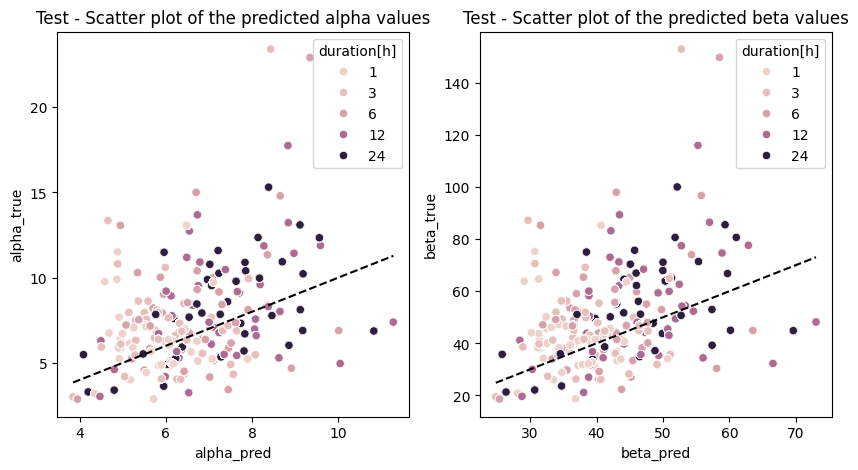

In [51]:
#train
#_ = util.parameters_metrics(dist_train_full, parameters_train, distribution_name = 'beta', calculate_metrics = False, title='Train')
#test
metrics_alpha_full, metrics_beta_full = util.parameters_metrics(dist_test_full, parameters_test, distribution_name='beta', indexes=durations_indexes_test, remove_outliers = False)

In [52]:
print('=============== FULL ALPHA PARAMETER===============')
display(metrics_alpha_full)
print('=============== FULL BETA PARAMETER===============')
metrics_beta_full

=============== FULL ALPHA PARAMETER===============


,global,1,3,6,12,24
biasr,0.037427,-0.003263,0.051834,0.067203,0.014070,0.057360
mape,0.268245,0.261574,0.263464,0.299253,0.268857,0.248033
pcc,0.376411,-0.042557,0.239431,0.330499,0.325498,0.478017


=============== FULL BETA PARAMETER===============


,global,1,3,6,12,24
biasr,0.057992,0.018052,0.074812,0.088413,0.030034,0.078721
mape,0.267840,0.266825,0.263935,0.297875,0.263706,0.246809
pcc,0.371996,-0.075758,0.231792,0.331596,0.323362,0.477953


* Metrics on parameters from PCA-model

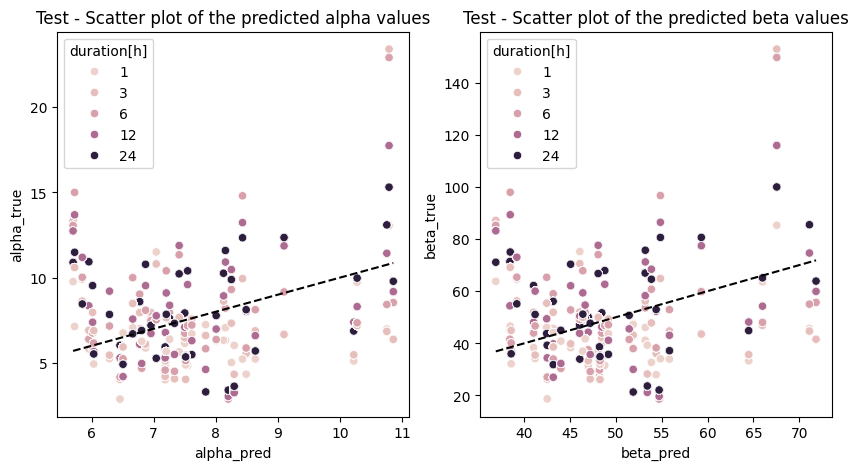

In [53]:
#_ = util.parameters_metrics(dist_train_pca, parameters_train, distribution_name = 'beta', calculate_metrics = False, title='Train')
metrics_alpha_pca, metrics_beta_pca = util.parameters_metrics(dist_test_pca, parameters_test, distribution_name='beta', indexes=durations_indexes_test, remove_outliers = False)

In [54]:
print('=============== PCA ALPHA PARAMETER===============')
display(metrics_alpha_pca)
print('=============== PCA BETA PARAMETER===============')
metrics_beta_pca

=============== PCA ALPHA PARAMETER===============


,global,1,3,6,12,24
biasr,-0.130333,-0.327114,-0.198672,-0.082119,-0.036049,-0.007383
mape,0.336285,0.403971,0.369131,0.330386,0.302202,0.275586
pcc,0.205064,0.195601,0.149754,0.215774,0.245525,0.287033


=============== PCA BETA PARAMETER===============


,global,1,3,6,12,24
biasr,-0.128856,-0.325180,-0.197618,-0.081476,-0.034439,-0.005239
mape,0.338154,0.405148,0.371955,0.332245,0.302728,0.278545
pcc,0.181690,0.167053,0.112833,0.185044,0.229960,0.278145


### 6.1 Comparison between two samples extracted from "true" and predicted distribution of the same place 

In [101]:
util = reload(util)


True alpha: 6.15, Predicted alpha: 7.50
True beta: 40.06, Predicted beta: 48.46
KS statistics:  0.0342


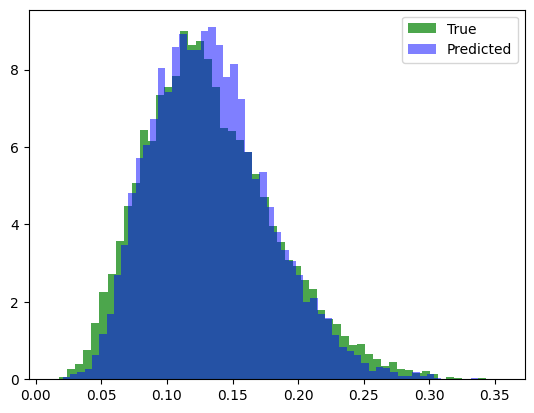

In [123]:
#util.compare_samples(dist_test_full, "beta", parameters_test, index=150)
#util.compare_samples(dist_test_map, "beta", parameters_test, index=20)
util.compare_samples(dist_test_pca, "beta", parameters_test, index=10)

## 6. Error Analysis


### 6.1 Beta Distribution

In [56]:
metrics_name = ['biasr', 'mape', 'pcc']
models_name = ['map', 'full', 'pca']
models_metrics = [ metrics_alpha_map, metrics_alpha_full, metrics_alpha_pca]

In [57]:
alpha_metrics = util.get_global_results(metrics_name,models_name,models_metrics)
alpha_metrics

,biasr_map,biasr_full,biasr_pca,mape_map,mape_full,mape_pca,pcc_map,pcc_full,pcc_pca
global,-0.117680,0.037427,-0.130333,0.295592,0.268245,0.336285,0.260718,0.376411,0.205064
1,-0.160442,-0.003263,-0.327114,0.271872,0.261574,0.403971,0.092340,-0.042557,0.195601
3,-0.115088,0.051834,-0.198672,0.277661,0.263464,0.369131,0.021777,0.239431,0.149754
6,-0.105595,0.067203,-0.082119,0.316469,0.299253,0.330386,0.088410,0.330499,0.215774
12,-0.109987,0.014070,-0.036049,0.314314,0.268857,0.302202,0.026096,0.325498,0.245525
24,-0.097220,0.057360,-0.007383,0.297653,0.248033,0.275586,0.053886,0.478017,0.287033


In [58]:
models_metrics = [ metrics_beta_map, metrics_beta_full, metrics_beta_pca]
beta_metrics = util.get_global_results(metrics_name,models_name,models_metrics)
beta_metrics

,biasr_map,biasr_full,biasr_pca,mape_map,mape_full,mape_pca,pcc_map,pcc_full,pcc_pca
global,-0.128304,0.057992,-0.128856,0.301395,0.267840,0.338154,0.260361,0.371996,0.181690
1,-0.162682,0.018052,-0.325180,0.275026,0.266825,0.405148,0.098130,-0.075758,0.167053
3,-0.140326,0.074812,-0.197618,0.289974,0.263935,0.371955,0.021259,0.231792,0.112833
6,-0.112675,0.088413,-0.081476,0.321053,0.297875,0.332245,0.081896,0.331596,0.185044
12,-0.125015,0.030034,-0.034439,0.320693,0.263706,0.302728,0.019137,0.323362,0.229960
24,-0.100752,0.078721,-0.005239,0.300234,0.246809,0.278545,0.059825,0.477953,0.278145


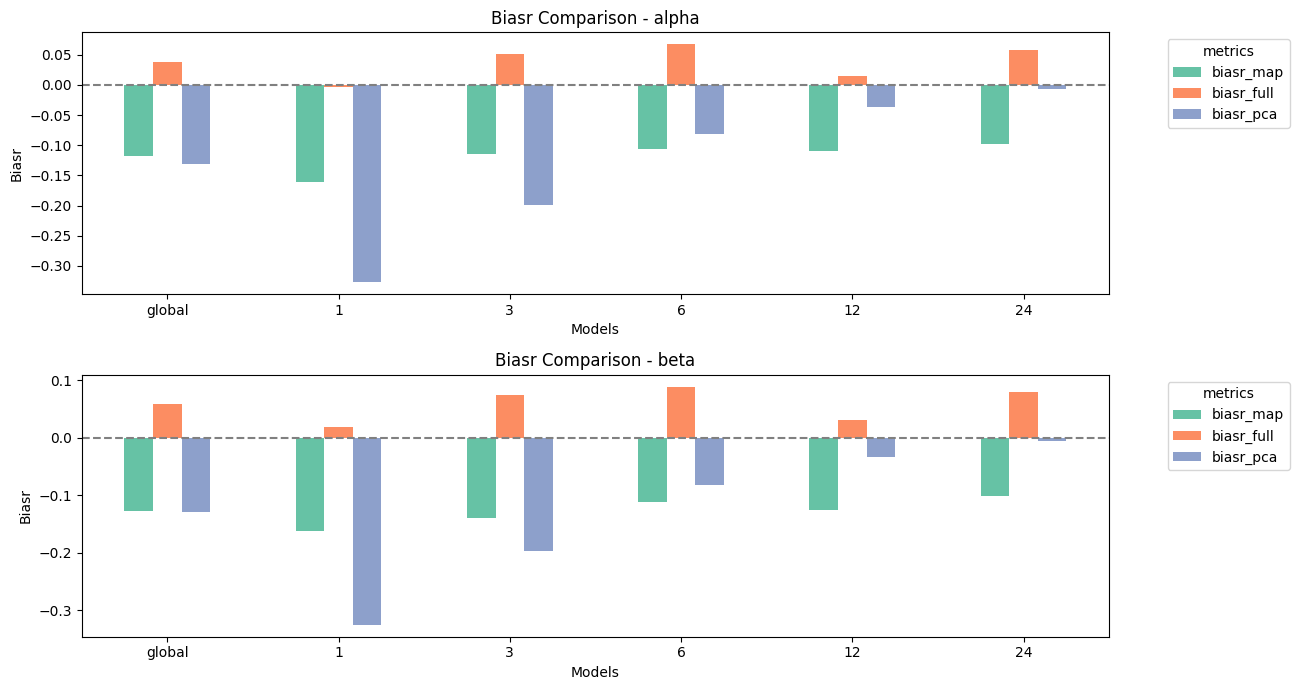

In [59]:
util.get_comparison_plot(alpha_metrics.iloc[:,0:3], beta_metrics.iloc[:,0:3], 'Biasr','beta', 'Set2')

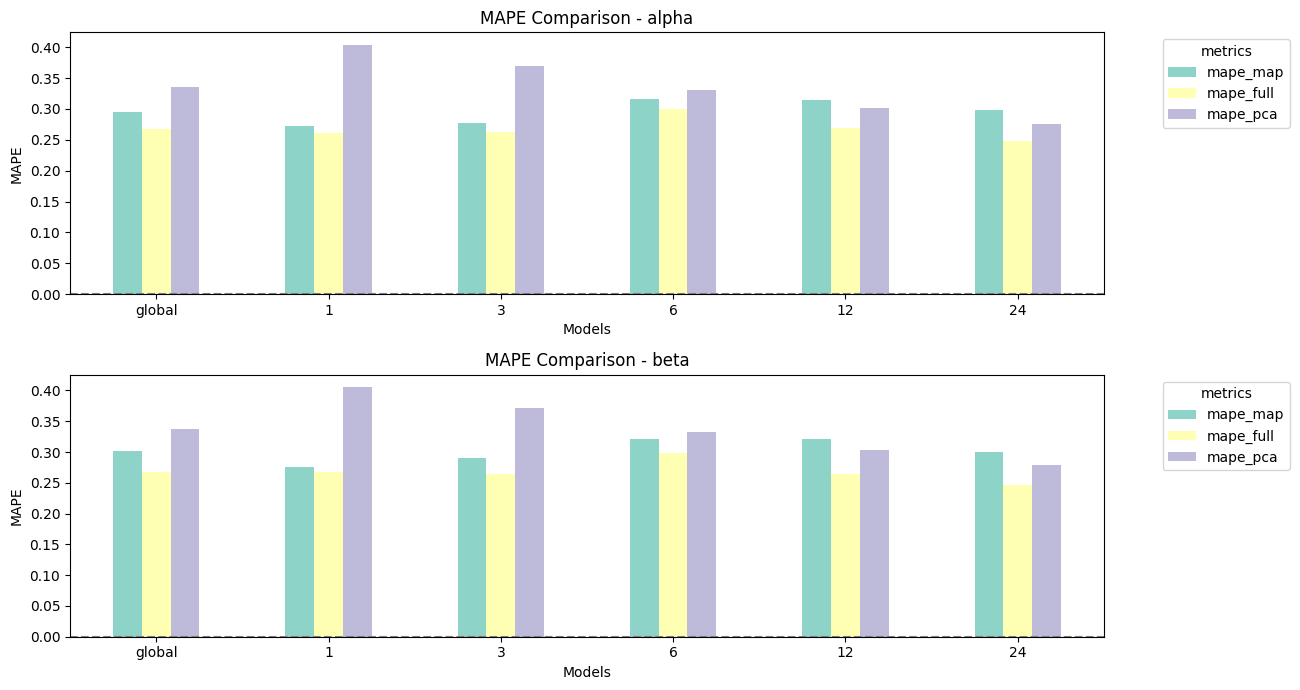

In [60]:
util.get_comparison_plot(alpha_metrics.iloc[:,3:6], beta_metrics.iloc[:,3:6], 'MAPE', 'beta','Set3')

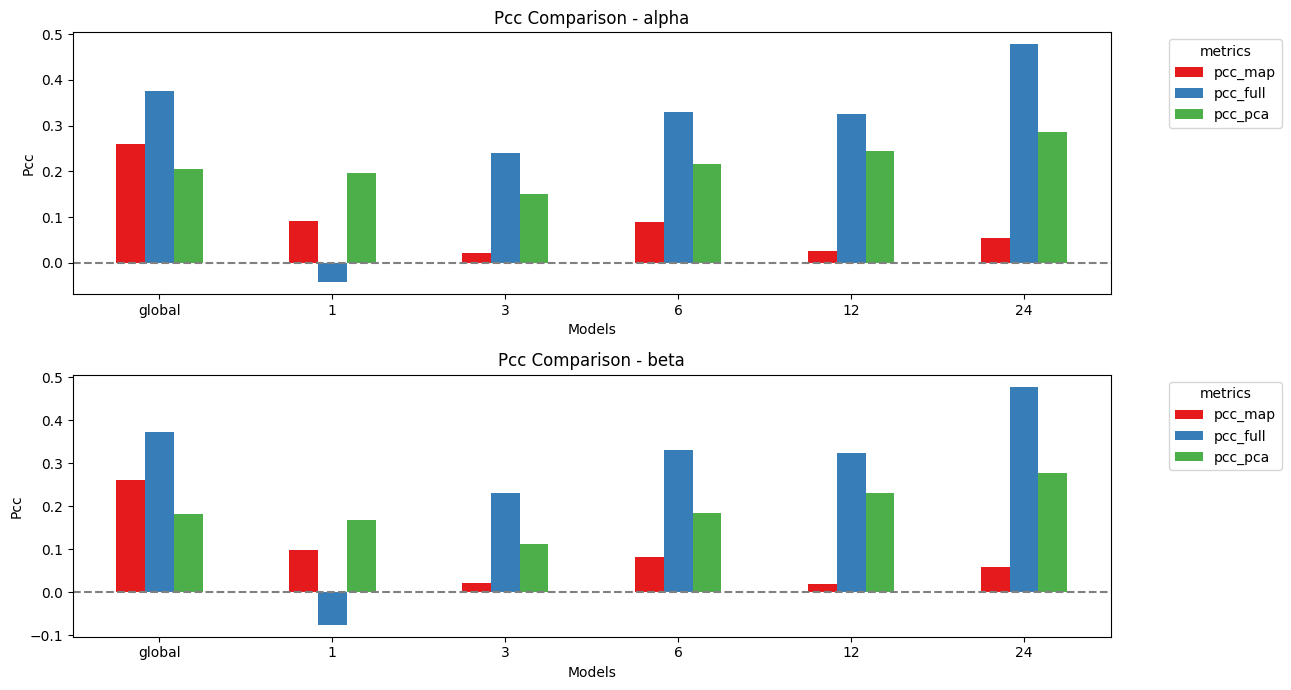

In [61]:
util.get_comparison_plot(alpha_metrics.iloc[:,6:9], beta_metrics.iloc[:,6:9], 'Pcc','beta', 'Set1')

The metrics used to evaluate the predictions on alpha and beta are: RMSE (Root Mean Squared Error), Relative Bias, and PCC (Pearson Correlation Coefficient).
- RMSE: It measures the difference between the values predicted by a model and the observed values, a lower value indicates better model accuracy. 
This is likely due to the wide variability in parameter values, making the model more prone to incorrectly predicting high values of alpha and beta.

- RBIAS:
If it is close to zero indicates that the model has a good tendency to predict values correctly, when it is positive the model tend to overestimate, while a negative relative bias indicates a tendency to underestimate the parameter.
 The Beta models tend to understimate the value of alpha and beta, in particular when considering the duration 1.

- PCC: It is a measure of the linear relationship between two variables.
It can range from -1 to 1. A value of 1 indicates a perfect positive correlation, -1 indicates a perfect negative correlation, and 0 indicates no linear correlation.



Observing the graph, one of the first notable things is that the models show specular performance in predicting alpha and in predicting beta. Global metrics do not always reflect what is obtained considering the individual durations in which the use of one model rather than the other can lead to different results.

( Sta cosa non ha nessun senso poi indago )
Comparing the different models, the best-performing one appears to be the MAP model, while the least performing one is the PCA model.

### 6.2 Gumbel Distribution

In [62]:
loc_metrics = pd.read_pickle('results/loc_metrics.pkl')
scale_metrics = pd.read_pickle('results/scale_metrics.pkl')

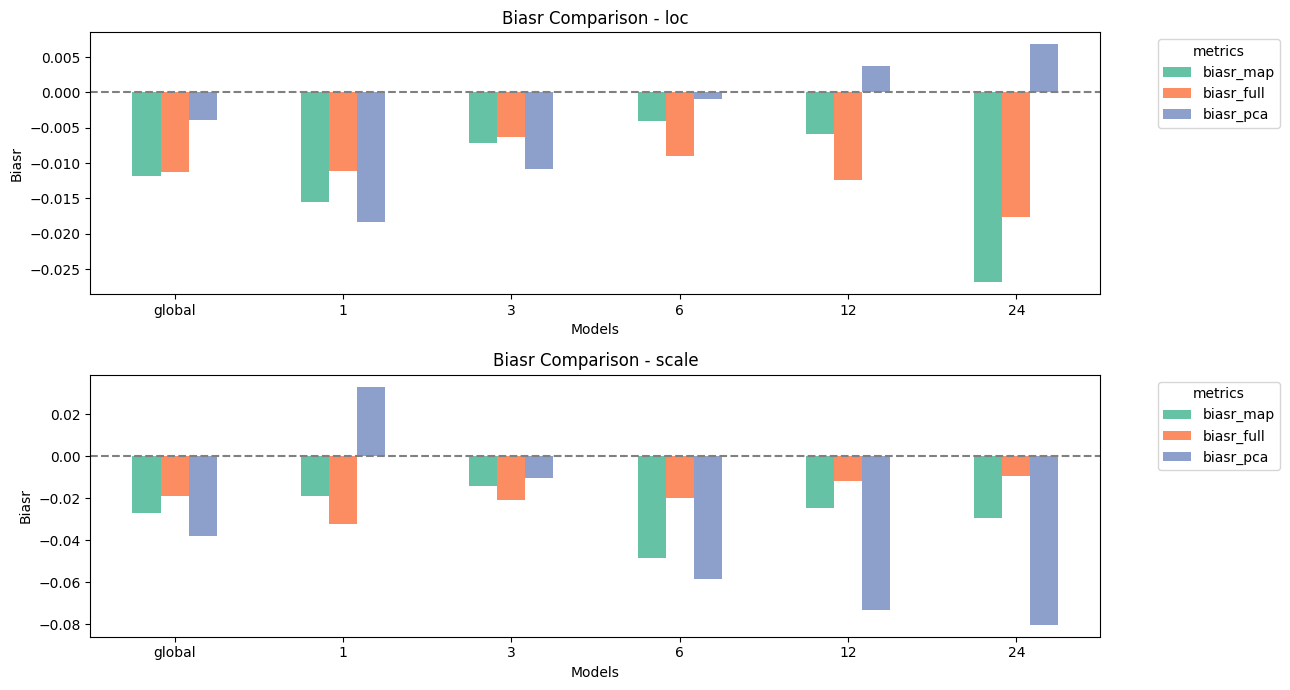

In [63]:
util.get_comparison_plot(loc_metrics.iloc[:,0:3], scale_metrics.iloc[:,0:3], 'Biasr','gumbel','Set2')

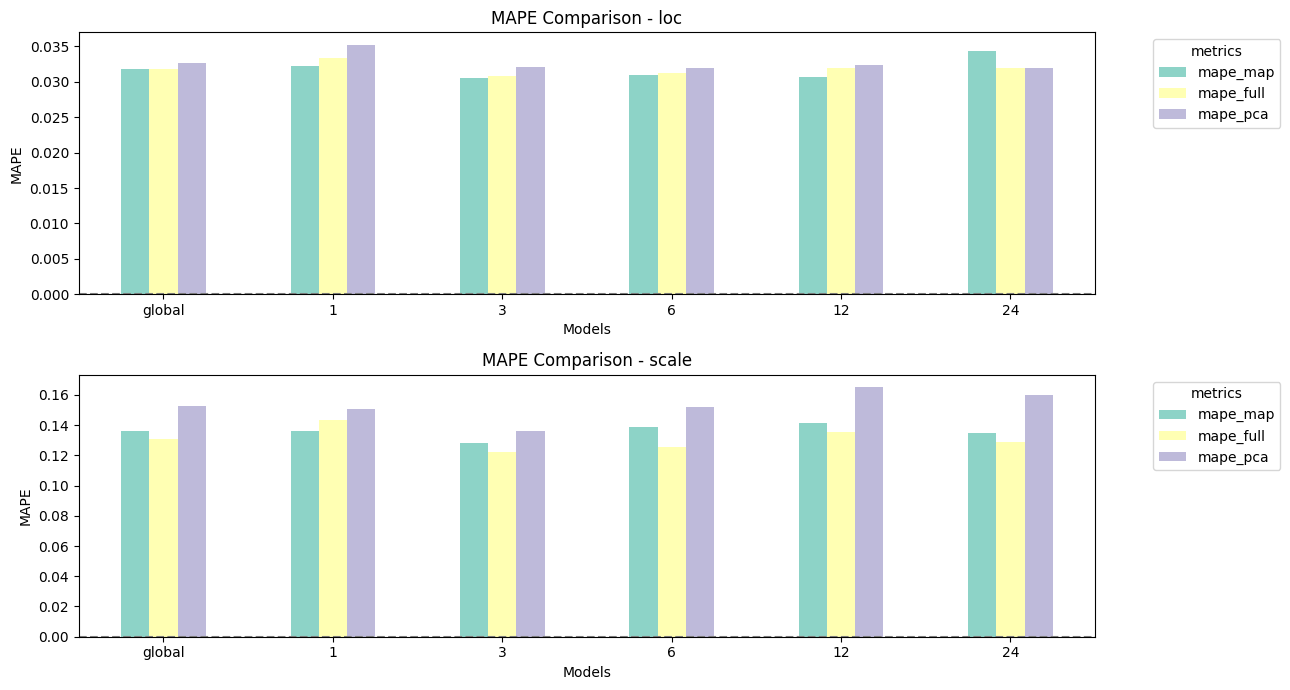

In [64]:
util.get_comparison_plot(loc_metrics.iloc[:,3:6], scale_metrics.iloc[:,3:6], 'MAPE', 'gumbel', 'Set3')

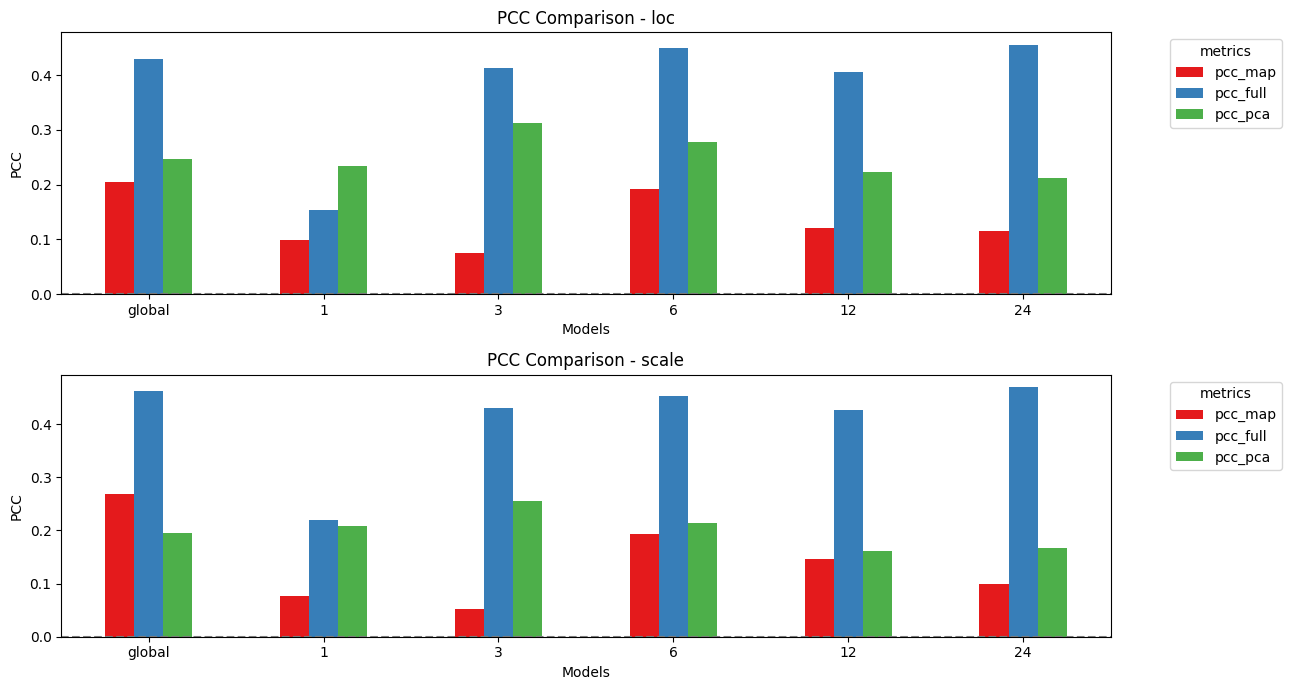

In [65]:
util.get_comparison_plot(loc_metrics.iloc[:,6:9], scale_metrics.iloc[:, 6:9], 'PCC', 'gumbel', 'Set1')

The results of the Gumbel are less symmetrical than those obtained with the Beta distribution. Observing the various metrics, the models therefore obtain different results for location and scale. In particular, the MAP model and the full model show similar results, generally better than those obtained through PCA

The metrics suggest that:

- All three models are capable of estimating the parameters fairly accurately with minimal errors (RMSE), often slightly underestimating them (RBias).
- The data does not exhibit a strong linear relationship (PCC)

### 6.3 Distributions Comparison

Since the results are all around the same order of magnitude, to compare the distributions we consider the 'global' values 

In [66]:
mape_comparison = pd.DataFrame()

In [67]:
mape_comparison["loc"] = loc_metrics.iloc[0,3:6].values
mape_comparison["scale"] = scale_metrics.iloc[0,3:6].values
mape_comparison["alpha"] = alpha_metrics.iloc[0,3:6].values
mape_comparison["beta"] = beta_metrics.iloc[0,3:6].values

In [68]:
mape_comparison.index = ['map', 'full', 'pca']
mape_comparison

,loc,scale,alpha,beta
map,0.031753,0.135962,0.295592,0.301395
full,0.031883,0.130949,0.268245,0.267840
pca,0.032736,0.152550,0.336285,0.338154


In [69]:
def plot_mape_comparison(df, title):
  fig, ax = plt.subplots(figsize=(18, 7))
  colors = sns.color_palette("Set2", 4)
  df.plot(kind='bar', ax=ax, rot=0, color=colors)

  plt.title('Scores Comparison'+" - " + title)
  plt.xlabel('Models')
  plt.ylabel('F1 Score')
  plt.legend(title='metrics', bbox_to_anchor=(1.05, 1), loc='upper left')
  #ax.invert_yaxis()
  plt.tight_layout()

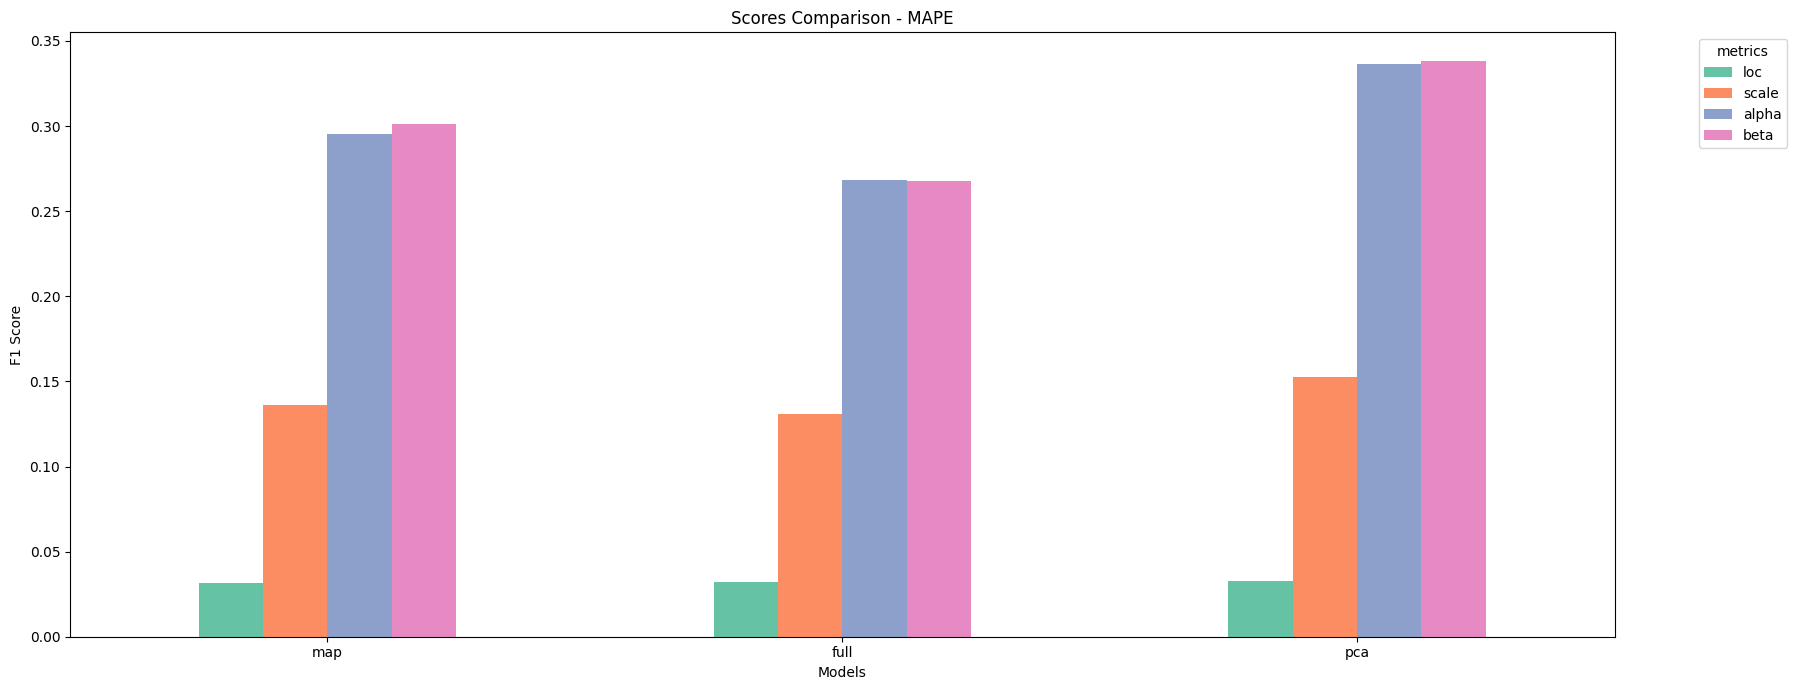

In [70]:
plot_mape_comparison(mape_comparison, 'MAPE')

For a more faithful comparison, we focused on the relative bias metrics as it is a dimensionless and independent of the magnitude of the values.
Observing the graph, it is evident that the estimates made by the Gumbel distribution are much more accurate than those of the Beta distribution,
However, it should be considered that we are considering the estimation made by the scipy fitter as the 'true' value for the parameter, and  there is no certainty that they are actually accurate. Greater confidence would be achieved if all measurements had an higher number of observations.